In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime as dt
from prophet import Prophet
from tqdm import tqdm, tqdm_notebook
import logging
import warnings
from datetime import timedelta
import collections

import matplotlib.pyplot as plt

In [13]:
warnings.filterwarnings('ignore')

#################
# Setup logging
#################

logger = logging.getLogger('consumption_forecasting')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('./consumption.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)
# Supress fbprophet output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Summary

Main steps of the workflow is:
1. Data Wrangling: Changing types, dealing with missing values etc
2. Data Analysis: Visualizing the data to find correlations and auto-correlation.
3. Feature Generation: Generating features such as date related features and mean/lagged values for features
4. Prediction: Predict the consumption for the test data given.

Prophet is used to forecast the consumption and it is used as a feature in XGBoost.
Train a separate prophet model, use the results as features used by the final model
(Prophet -> XGBoost + Lags)

*'Consumption' is named as 'sales' in the pipeline

In [48]:
####################
# HELPER FUNCTIONS
####################


def create_prophet_features(train):
    """
    Train a seperate fbprophet model
    Use the results as features used by the final model
    """
    logger.info('creating prophet models for features')
    grouped = train.copy()
    prophet_results = []
    grouped.date = grouped.date.dt.tz_localize(None)
    m = Prophet(uncertainty_samples=1000, daily_seasonality=False, interval_width = 0.95)
    m.fit(grouped.rename(columns={'date': 'ds', 'sales': 'y'}))
    future = m.make_future_dataframe(periods=168, freq='H')
    forecast = m.predict(future)

    prophet_results.append(forecast)
    prophet_features = pd.concat(prophet_results)
    prophet_features = prophet_features.rename(columns={'ds': 'date'})
    prophet_features.to_csv('prophet_results.csv')
    return prophet_features


def add_lags(df, date_col='date', target='sales'):
    """
    Using the ``date_col`` adds columns with values for ``target``
    on the same date the prior year for the same ``by_vars``.

    Parameters
    ---------
    df : pandas dataframe
         Dataframe with ``date_col``, ``by_vars`` and ``target`` that
         will be used to identify the same date last year.
    date_col : string of date column
    by_vars : list of by vars
    target : string of target column
    Returns
    ---------
    df : pandas dataframe
        Dataframe with same time last year columns added.
    """
    logger.info('Adding lag features')

    days_back_list = [x * 2 for x in range(1, 51, 10)]

    df = df[[date_col] + [target]].copy()
    df[date_col] = pd.to_datetime(df[date_col], utc = True)
    new_cols = []
    for days_back in days_back_list:
        df_for_join = df.copy()
        df_for_join['{}_min{}'.format(date_col, days_back)] = \
            df_for_join[date_col] - pd.Timedelta('-{} days'.format(days_back))
        left_on = [date_col]
        right_on = ['{}_min{}'.format(date_col, days_back)]
        df_merged = df.merge(df_for_join,
                             left_on=left_on,
                             right_on=right_on,
                             suffixes=('', '_min{}'.format(days_back)),
                             how='left') \
            .drop(columns=['{}_min{}'.format(date_col, days_back)])
        new_cols.append(df_merged['{}_min{}'.format(target, days_back)])
    new_cols_df = pd.DataFrame(new_cols).T
    df_with_lags = pd.concat([df, new_cols_df], axis=1)

    df_with_lags_avgs = add_averages(df_with_lags)
    return df_with_lags_avgs


def add_averages(df):
    logger.info('Adding averages features')

    df['month'] = df['date'].dt.month
    df['weekofyear'] = df['date'].dt.weekofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['daily_avg'] = df.groupby(['dayofweek'])[
        'sales'].transform('mean')
    df['monthly_avg'] = df.groupby(['month'])[
        'sales'].transform('mean')
    df['week_avg'] = df.groupby(['weekofyear'])[
        'sales'].transform('mean')
    df['monthly_store_avg'] = df.groupby(['month'])[
        'sales'].transform('mean')

    return df.drop(['month', 'dayofweek'], axis=1)

# Create Features


def create_features(df, labeled=True):
    """
    Creates the features used by model from raw data
    """
    logger.info('Creating features used by model')

    df['date'] = pd.to_datetime(df['date'], utc = True)
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['hour'] = df['date'].dt.hour
    # Sine waves representation of doy, completely out of shift from eachother
    df['cos_doy'] = np.cos((df['dayofyear'] * 2 * np.pi) / 364)
    df['neg_sin_doy'] = - np.sin((df['dayofyear'] * 2 * np.pi) / 364)

    # Make Dummies
    dow_dummies = pd.get_dummies(df['dayofweek'], prefix='dow')

    # Lag variables
    lags = df[[x for x in df.columns if x[:6] == 'sales_']]

    df.loc[(df['dayofyear'] > 150) & (df['dayofyear'] < 250), 'is_summer'] = 1
    df['is_summer'] = df['is_summer'].fillna(0)

    all_features = [df['dayofweek'], df['quarter'], df['month'],
                    df['year'], df['dayofyear'], df['dayofmonth'],
                    df['weekofyear'], df['hour'], df['cos_doy'], df['neg_sin_doy'],
                    dow_dummies,
                    lags,
                    df['temp'], df['rhum'], df['prcp'], df['snow'], df['wdir'], df['wspd'],
                    df['pres'], df['coco'], df['el_price'],
                    df['daily_avg'], df['monthly_avg'],
                    df['is_summer'],
                    df['week_avg'], df['monthly_store_avg'],
                    df['trend'], df['yhat_lower'], df['yhat_upper'],
                    df['trend_lower'], df['trend_upper'], df['additive_terms'],
                    df['additive_terms_lower'], df['additive_terms_upper'],
                    df['weekly'], df['weekly_lower'], df['weekly_upper'],
                    df['yhat']]

    X = pd.concat(all_features, axis=1)

    if labeled:
        y = df['sales']
        return X, y, np.log1p(y)
    return X


def filter_features(X, features):
    """
    Filters X down to just the features we want the model to use.
    Params
    ------
    X (Pandas dataframe) : Dataframe with all features.
    features (list) : list of features to keep columns
    """
    logger.info('filtering down features')
    return X

####################
# PIPELINE
####################

def preprocess(train, test, load_prohet_csv=False):
    """
    Preprocess train and test including.
    1. Joining train/test
    2. Creating prophet features
    3. Creating lags and mean values
    4. Splitting back into train/test
    """
    logger.info('preprocessing data')

    all_data = pd.concat([train, test], sort=False).copy()
    all_data = all_data.reset_index().drop('index', axis=1)
    all_data['date'] = pd.to_datetime(all_data['date'], utc = True)
    # Add prophet features and merge on all data
    if load_prohet_csv:
        prophet_features = pd.read_csv('prophet_results.csv', index_col=[0])
        prophet_features['date'] = pd.to_datetime(prophet_features['date'], utc = True)
    else:
        prophet_features = create_prophet_features(train)

    # Prophet feature columns
    prophet_features.date = pd.to_datetime(prophet_features['date'], utc = True)
    all_data = all_data.merge(prophet_features, on=['date'], how='left')

    # Create lags and add prophet features
    all_data_lags = add_lags(all_data)
    all_data_lags.date = pd.to_datetime(all_data_lags['date'], utc = True)

    all_data = all_data.merge(all_data_lags, on=['date','sales'], how='left')


    # Adding lags
    test_with_lags = all_data.loc[all_data['sales'].isna()].copy()
    train_with_lags = all_data.loc[~all_data['sales'].isna()].copy()

    # Create Features

    X_train, y_train, y_log_train = create_features(train_with_lags)
    X_test = create_features(test_with_lags, labeled=False)
    return X_train, y_train, X_test


def run_pipeline_final(train, X_train, y_train,
                       features, params, verbose=False):
    """
    Pipeline function that runs the model process based on input data
    and features.
    """
    logger.info('running the pipeline')

    # Filter Features
    X_train = filter_features(X_train, features)

    # Give more weight to the month's we will submit for in the end
    train.loc[train.date.dt.month.isin([7,8]), 'sample_weight'] = 1
    train['sample_weight'] = train['sample_weight'].fillna(0.2)

    reg = xgb.XGBRegressor(n_jobs=4, **params)

    reg.fit(X=X_train, y=y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='rmse',
            early_stopping_rounds=10,
            verbose=verbose,)

    return reg


def create_df_with_preds(reg, test, train,
                         X_train, X_test, features,
                         save_csv=True):
    """
    Creates test and train with the predictions added
    """
    logger.info('creating dataframe with predictions')

    X_test = filter_features(X_test, features)
    X_train = filter_features(X_train, features)

    test['sales_pred_test'] = reg.predict(X_test)
    train['sales_pred_train'] = reg.predict(X_train)

    joined_preds = pd.concat([test, train])

    now = dt.datetime.now()
    dateandtime = now.strftime('%b%d-%H%m')
    test = test.rename(columns={'date':'time', 'sales_pred_test': 'consumption'})[['time', 'consumption']]
    test.to_csv('sub2.csv'.format(dateandtime), index=False)
    return test


def create_submit(reg, X_test, submit, features):
    """
    Creates the submission CSV
    """
    submit['sales'] = reg.predict(X_test)
    now = dt.datetime.now()
    dateandtime = now.strftime('%b%d-%H%m')
    logger.info('creating submission csv')
    submit = submit.drop('consumption', axis=1)
    submit.columns = ['time', 'consumption']
    submit.to_csv('submit1.csv', index=False)

    return


In [49]:

####################
# DATA WRANGLING #########
####################


# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

train.columns = ['date', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd',
                 'wpgt', 'pres', 'coco', 'el_price', 'sales']
test.columns = ['date', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd',
                 'wpgt', 'pres', 'coco', 'el_price']
internal_features = ['temp', 'rhum', 'prcp', 'snow', 'wdir', 'wspd',
                  'pres', 'coco', 'el_price']


train['date'] = pd.to_datetime(train['date'], utc=True)
test['date'] = pd.to_datetime(test['date'], utc=True)
def data_wrangling(df):
    coco_input = df.coco.value_counts(normalize=True).to_frame().reset_index().iloc[0]['index']
    df.coco.fillna(coco_input, inplace=True)
    df = df.fillna(0)
    df = df.drop(['dwpt', 'wpgt'], axis=1)
    return df

train = data_wrangling(train)
test = data_wrangling(test)

In [54]:
train_internal = train[internal_features]
test_internal = test[internal_features]

df, y_vis, _ = preprocess(train, test, load_prohet_csv=False)

df['consumption'] = y_vis

17:52:10 - cmdstanpy - INFO - Chain [1] start processing
17:52:10 - cmdstanpy - INFO - Chain [1] done processing


How to test for seasonality of a time series?
The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

Hour of day
Day of month
Weekly
Monthly
Yearly

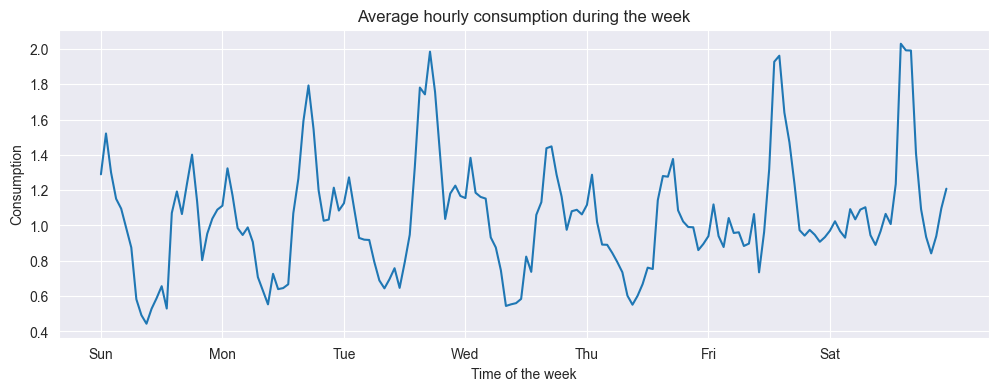

In [56]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["dayofweek", "hour"]).mean()["consumption"]
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly consumption during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Consumption",
)



[]

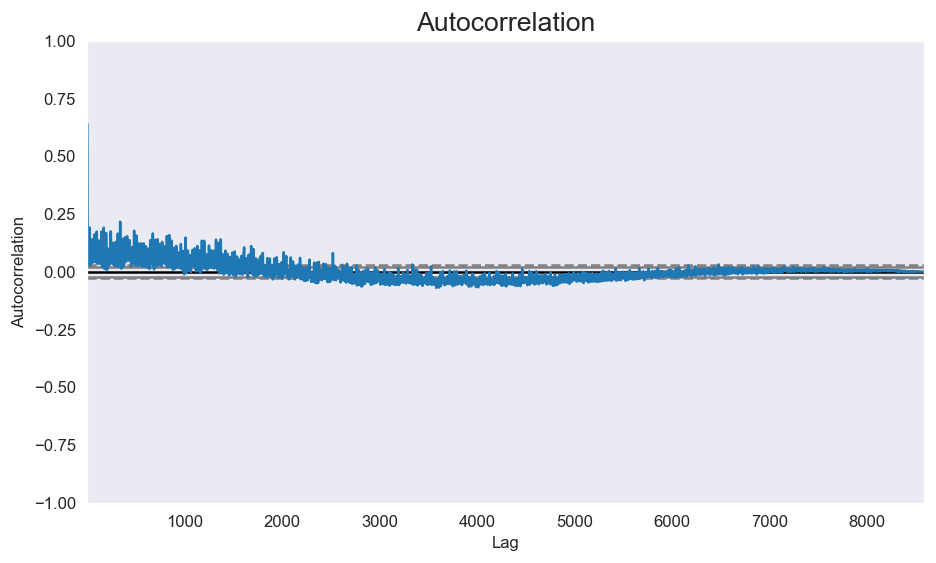

In [57]:

from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize': (9, 5), 'figure.dpi': 120})
autocorrelation_plot(df.consumption.tolist())
plt.title('Autocorrelation', fontsize=16)
plt.plot()


A slowly-decaying ACF plot indicates that there is significant autocorrelation in the data. This suggests that the time series data exhibits some level of persistence, and that previous observations can be used to predict future values.

In [59]:
df[['consumption', 'dayofweek']].groupby(['dayofweek'], as_index=True).mean().sort_values(by='consumption',ascending=False)


,consumption
dayofweek,
6,1.160770
2,1.117835
5,1.108913
1,1.034487
3,1.005435
0,0.959306
4,0.934894


<AxesSubplot: xlabel='month', ylabel='consumption'>

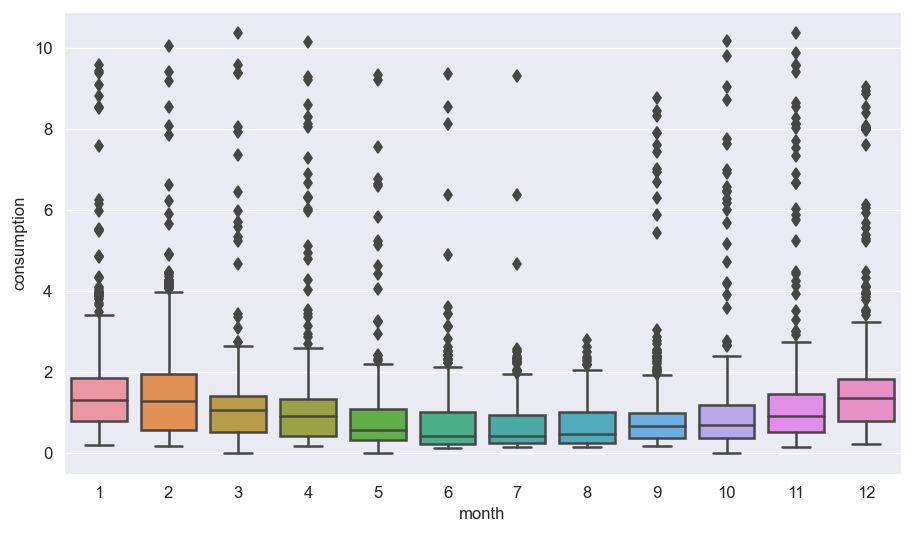

In [60]:

import seaborn as sns

sns.boxplot(x='month', y='consumption', data=df)

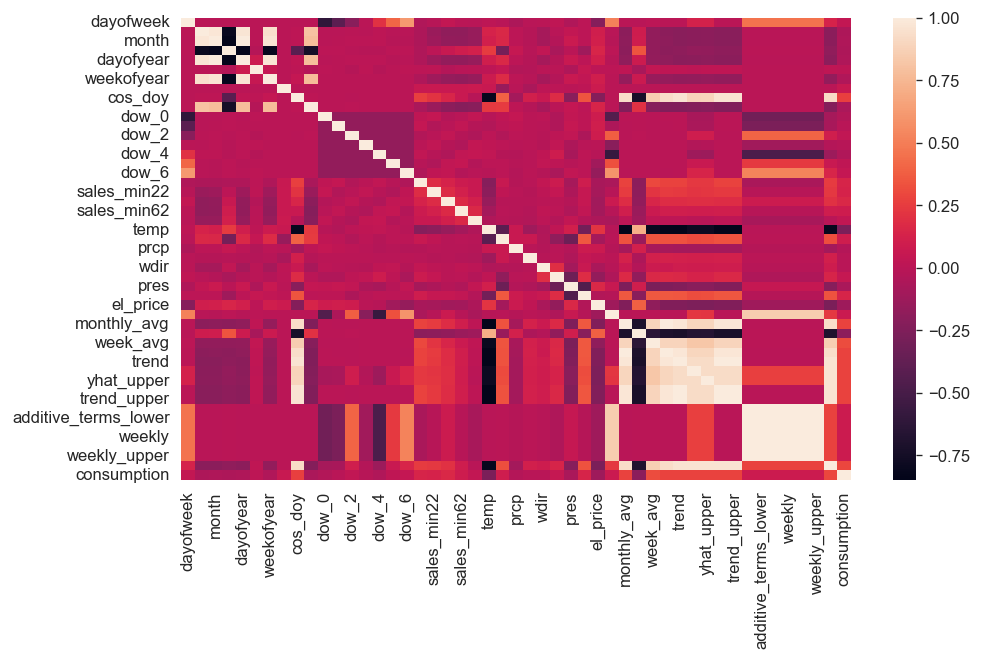

In [61]:

sns.heatmap(df.corr());

Let us drop correlated features, there happen to be 2. dwpt and wpgt


Let us rescale the target variable (number of hourly bike rentals) to predict a relative demand so that the mean absolute error is more easily interpreted as a fraction of the maximum demand.

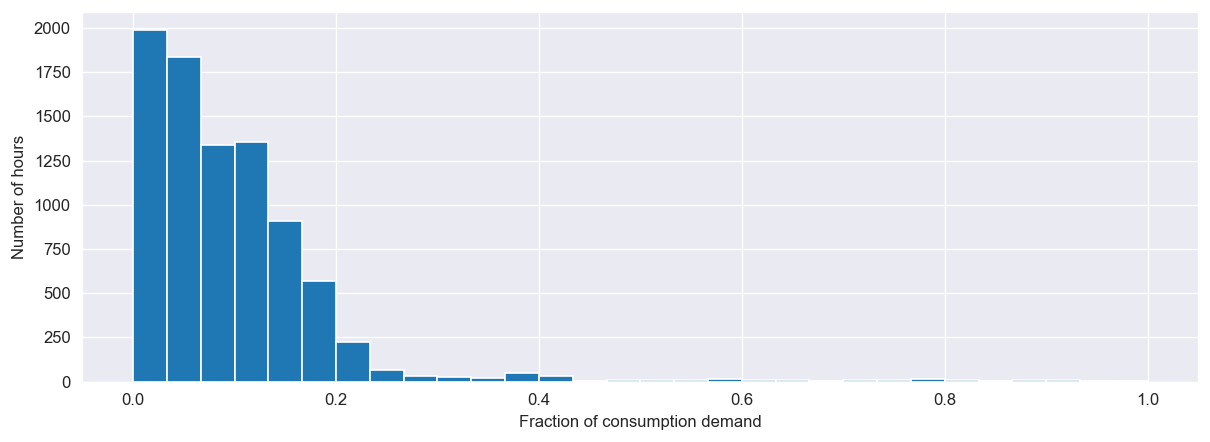

In [62]:

target = df["consumption"] / df["consumption"].max()
fig, ax = plt.subplots(figsize=(12, 4))
target.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of consumption demand",
    ylabel="Number of hours",
)

<AxesSubplot: xlabel='consumption'>

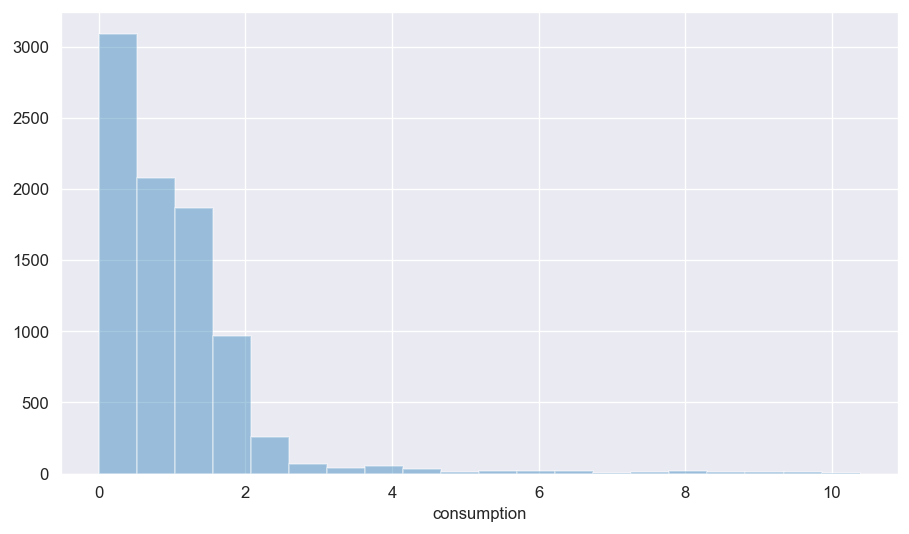

In [63]:
sns.distplot(df['consumption'], kde=False, bins=20)


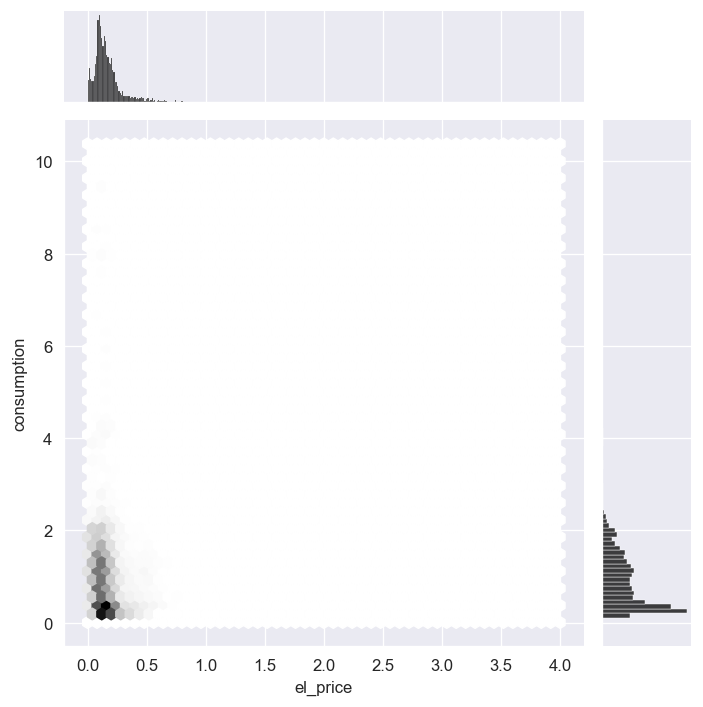

In [64]:
sns.jointplot(x='el_price', y='consumption', data=df, kind='hex', color='black')

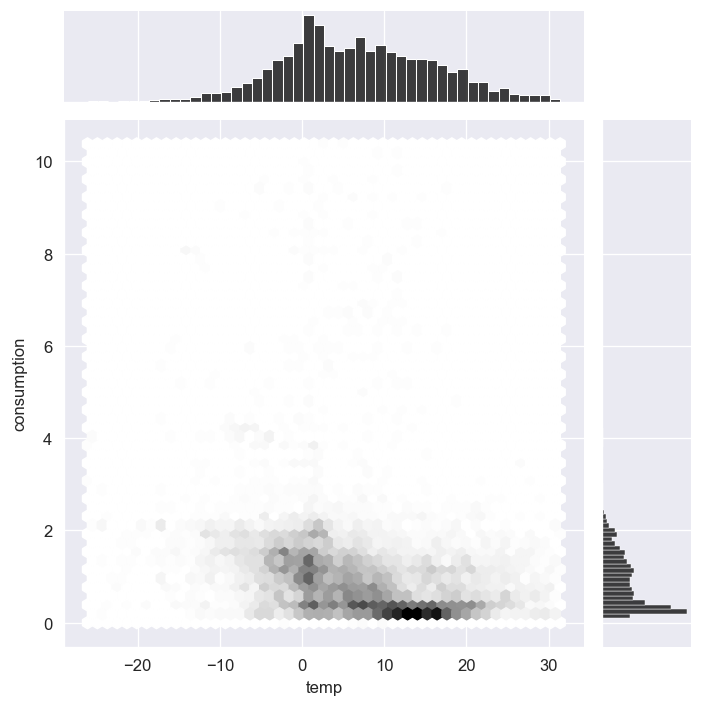

In [65]:

sns.jointplot(x='temp', y='consumption', data=df, kind='hex', color='black')

In [43]:
# 1. Preprocess
try:
    X_train, y_train, X_test = preprocess(train, test, load_prohet_csv=False)
except Exception as e:
    logger.error('Preprocessing broke.')
    logger.error(e)
# 2. Set Features and params to use
params = {'subsample': 0.75,
          'n_estimators': 10000,
          'min_child_weight': 3,
          'max_depth': 9,
          'learning_rate': 0.001,
          'gamma': 0.9,
          }

features = ['dayofweek', 'quarter', 'month', 'year', 'dayofmonth',
            'temp',	'dwpt', 'rhum',	'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco','el_price',
            'weekofyear', 'hour', 'cos_doy', 'neg_sin_doy',
            'dayofyear', 'sales_min2', 'sales_min22',
            'sales_min42', 'sales_min62', 'sales_min82', 'sales_min102',
            'daily_avg', 'monthly_avg',
            'is_summer', 'week_avg', 'monthly_store_avg',
            'trend', 'yhat', 'yhat_lower', 'yhat_upper',
            'trend_lower', 'trend_upper', 'additive_terms',
            'additive_terms_lower', 'additive_terms_upper',
            'weekly', 'weekly_lower', 'weekly_upper',]

17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing


In [18]:

train['date'] = train['date'] + timedelta(hours=3)
test['date'] = test['date'] + timedelta(hours=3)

In [19]:

# 3. Train Model
reg = run_pipeline_final(train, X_train, y_train, features, params, verbose=False)

bst = reg.get_booster()
print('FSCORES:')
print(sorted(bst.get_fscore().items(), key=lambda x: x[1]))

FSCORES:
[('is_summer', 47.0), ('dow_4', 651.0), ('prcp', 707.0), ('snow', 940.0), ('dow_2', 1121.0), ('weekofyear', 1239.0), ('monthly_avg', 1301.0), ('quarter', 1549.0), ('month', 1569.0), ('dow_3', 2092.0), ('daily_avg', 2587.0), ('dow_5', 2657.0), ('dow_1', 2662.0), ('cos_doy', 11357.0), ('wspd', 13194.0), ('week_avg', 13321.0), ('dayofweek', 14221.0), ('dayofyear', 15636.0), ('coco', 16584.0), ('neg_sin_doy', 18259.0), ('dayofmonth', 18424.0), ('wdir', 21162.0), ('trend', 26280.0), ('yhat', 27938.0), ('yhat_upper', 31387.0), ('yhat_lower', 33621.0), ('rhum', 34157.0), ('additive_terms', 41734.0), ('pres', 42779.0), ('sales_min82', 45311.0), ('sales_min62', 46552.0), ('temp', 48354.0), ('sales_min22', 52019.0), ('sales_min42', 53482.0), ('sales_min2', 58152.0), ('el_price', 59760.0)]


In [20]:
# 4. Save Predictions for later evaluation
try:
    _ = create_df_with_preds(reg, test, train, X_train, X_test, features, save_csv=True)
except Exception as e:
    logger.error('Creating combined df broke.')
    logger.error(e)

In [21]:
# 5. Create Submission
try:
    create_submit(reg, X_test, submit, features)
except Exception as e:
    logger.error('creating submission broke.')
    logger.error(e)

In [22]:
text = open("sub2.csv", "r")

#join() method combines all contents of
# csvfile.csv and formed as a string
text = ''.join([i for i in text])

# search and replace the contents
text = text.replace("+00:00", "+03:00")

# output.csv is the output file opened in write mode
x = open("sub2.csv","w")

# all the replaced text is written in the output.csv file
x.writelines(text)
x.close()